In [4]:
import matplotlib.pyplot as plt
import numpy as np

x_train, y_train, x_test, y_test = (
    np.load("../1090/x_train.npy"),
    np.load("../1090/y_train.npy"),
    np.load("../1090/x_test.npy"),
    np.load("../1090/y_test.npy"),
)

print(x_train.shape)
# out: (84545, 11)

(84545, 11)


## High bin-count plots

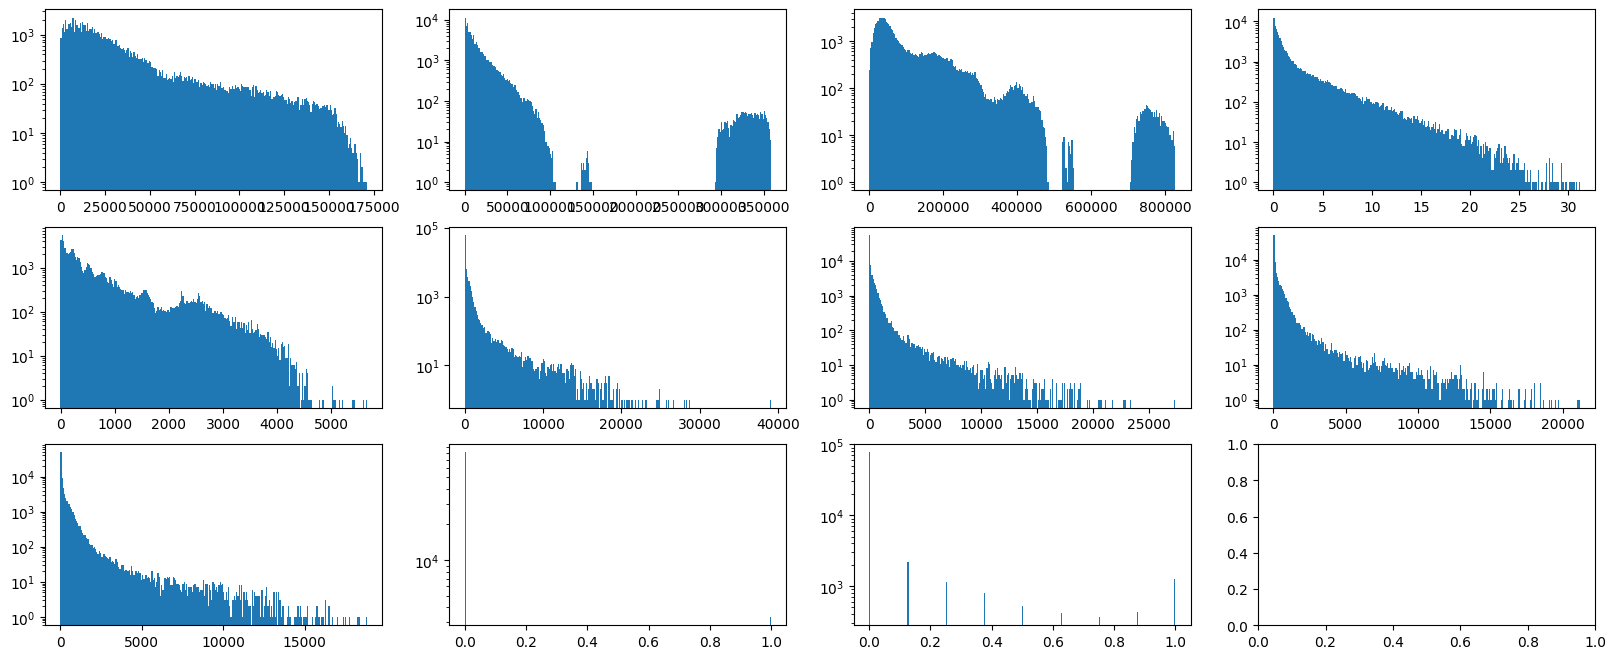

In [5]:
n_features = x_train.shape[1]

fig, ax = plt.subplots(3, 4, figsize=(20,8))

for i in range(n_features):
    ax.flat[i].hist(x_train[:,i], bins=256)
    ax.flat[i].set_yscale("log")


In [6]:
def new_gax():
    fig = plt.figure(figsize=(20,8))
    gax = fig.add_subplot(111)

    gax.spines['top'].set_color('none')
    gax.spines['bottom'].set_color('none')
    gax.spines['left'].set_color('none')
    gax.spines['right'].set_color('none')
    gax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

    return fig, gax

## Scatter plot of all features

With the same naming as used in C++.
The plot represents the `index` structure.

- `index.val` represents the measurement index, i.e. the row number in the data table
- `index.key` represents the measurement value, i.e. the value in the corresponding row

Text(0, 0.5, 'key')

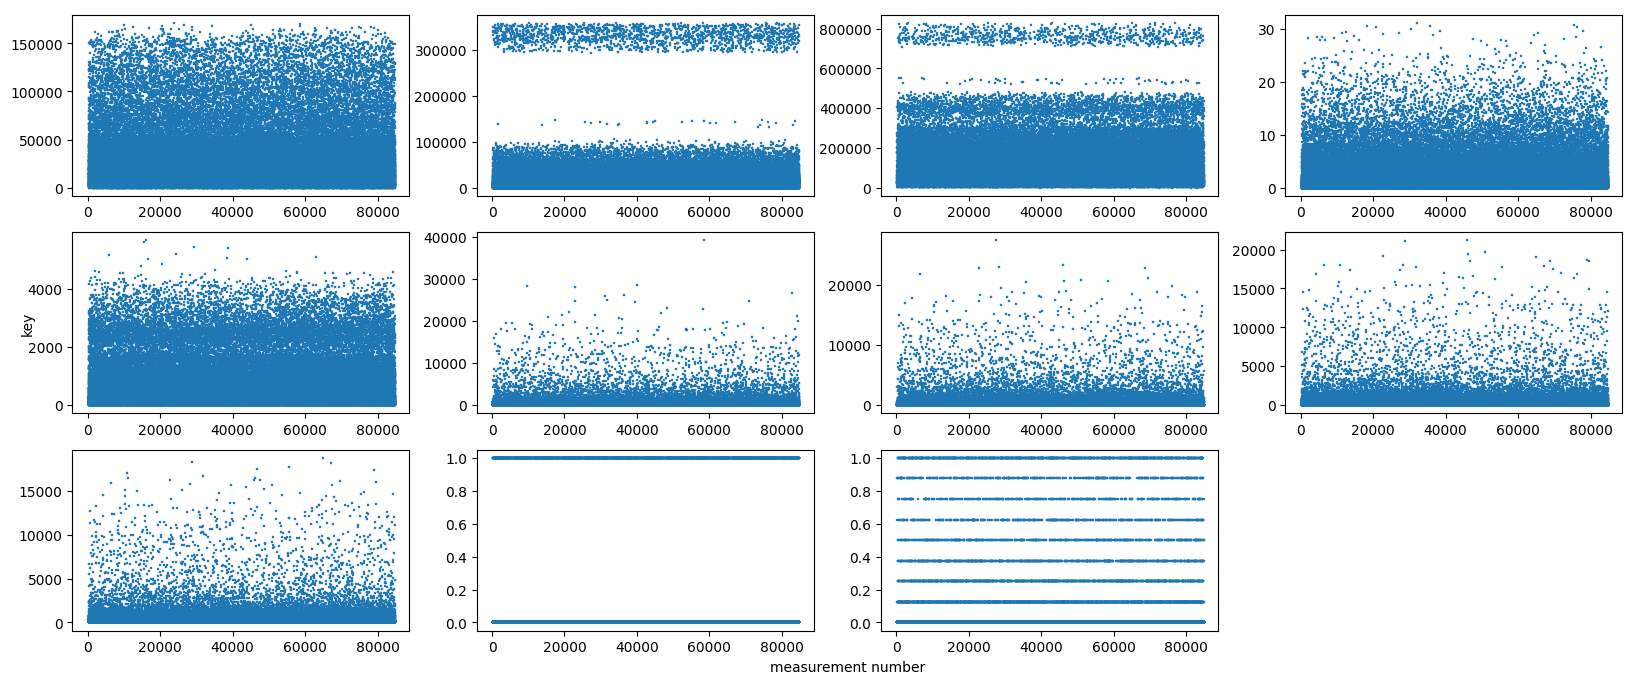

In [7]:
fig, gax = new_gax()

index = np.arange(x_train.shape[0])

for i in range(n_features):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.scatter(index, x_train[:,i], marker=",", s=(72/fig.dpi)**2)

gax.set_xlabel("measurement number")
gax.set_ylabel("key")

In C++, the `index` structure gets sorted. Here is what this looks like

Text(0, 0.5, 'index[i].key')

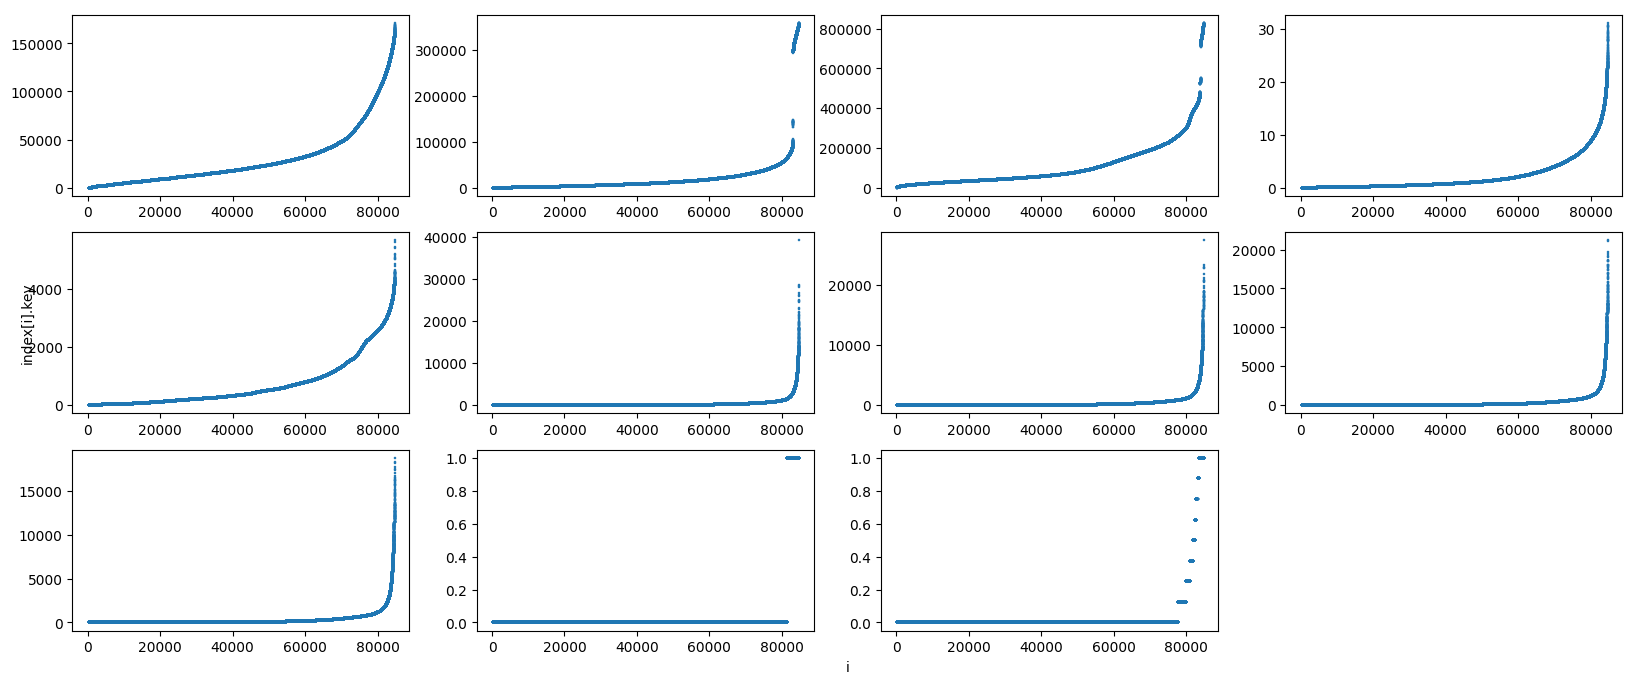

In [8]:
fig = plt.figure(figsize=(20,8))
gax = fig.add_subplot(111)

index = np.arange(x_train.shape[0])

for i in range(n_features):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.scatter(index, np.sort(x_train[:,i]), marker=",", s=(72/fig.dpi)**2)

gax.spines['top'].set_color('none')
gax.spines['bottom'].set_color('none')
gax.spines['left'].set_color('none')
gax.spines['right'].set_color('none')
gax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

gax.set_xlabel("i")
gax.set_ylabel("index[i].key")

## Emulating the `index` structure

In [9]:
class Index:
    def __init__(self, val, key):
        self.val = val
        self.key = key

    def __repr__(self):
        return f"<Index: {self.val=}, {self.key=}"

class IndexPointer:
    def __init__(self, val_array, key_array):
        self.val_array = val_array
        self.key_array = key_array

        assert len(val_array) == len(key_array)

    def __getitem__(self, idx):
        return Index(self.val_array[idx], self.key_array[idx])

    def __len__(self):
        return len(self.val_array)

features = list(
    IndexPointer(
    np.arange(x_train.shape[0]),
    np.sort(x_train[:,i])) 
    for i in range(n_features)
)

f0 = features[0]

## Mimicking the C++ binning algo

In [10]:
max_bins = 256    # df_training_parameter.cpp
min_bin_size = 5  # df_training_parameter.cpp

def get_bins(index):
    """ 
    Calculates how many data entries are contained per bin 
    That is, if the function returns [5, 10, 5], then there are 3 bins, and
      - data[0, ..., 4] is in bin0
      - data[5, ..., 14] is in bin1
      - data[15, ..., 19] is in bin2
    """

    bins = []

    n_rows = len(index)
    bin_size = n_rows // max_bins
    i = 0
    while i + bin_size < n_rows and len(bins) < max_bins:
        new_bin_size = bin_size
        i_right = i + new_bin_size - 1
        ri = index[i_right]

        if ri.key == index[i_right + 1].key:
            i_right += 1
            r = i_right + bin_size
            while r < n_rows and index[r].key == ri.key:
                r += bin_size
            if r > n_rows:
                r = n_rows
            
            while index[r - 1].key != ri.key:
                r -= 1
            
            i_right = r
            new_bin_size = i_right - i

            if new_bin_size >= 2* bin_size:
                i_closest_smaller_value = i + bin_size - 1
                while i_closest_smaller_value > i and index[i_closest_smaller_value].key == ri.key:
                    i_closest_smaller_value -= 1
                dist = i_closest_smaller_value - i
                if dist > min_bin_size:
                    new_left_bin_size = dist + 1
                    bins.append(new_left_bin_size)
                    i += new_left_bin_size
                elif len(bins) > 0 and dist:
                    n_add_to_prev_bin = dist + 1
                    bins[-1] += n_add_to_prev_bin
                    i += n_add_to_prev_bin
                    new_bin_size -= n_add_to_prev_bin


        bins.append(new_bin_size)
        i += new_bin_size

    # accumulate the remaining data points in a single bin
    if i < n_rows:
        new_bin_size = n_rows - i
        if (len(bins) < max_bins and new_bin_size >= min_bin_size) or len(bins) == 0:
            bins.append(new_bin_size)
        else:
            bins[-1] += new_bin_size

    return bins

def get_bin_borders_from_bins(bins):
    return list((sum(bins[:i]) for i in range(len(bins) + 1)))

def get_bin_averages(data, bins):
    averages = []
    for i in range(len(bins) - 1):
        start, stop = bins[i], bins[i+1]     
        averages.append(np.mean(data[start:stop]))
    averages.append(averages[-1])  # duplicate final value to solve plotting issue with ax.step
    return np.array(averages)

def get_bin_std(data, bins):
    std = []
    for i in range(len(bins) - 1):
        start, stop = bins[i], bins[i+1]     
        std.append(np.std(data[start:stop]))
    std.append(std[-1])  # duplicate final value to solve plotting issue with ax.step
    return np.array(std    )

### Validate binning algo

In [11]:
borders = get_bin_borders_from_bins(get_bins(f0))
assert borders[0] == 0
assert borders[-1] == len(f0), f"borders[-1] = {borders[-1]}, len(f0) = {len(f0)}"

### Overlaying the bin algo to the data

Text(35.06944444444445, 0.5, 'index[i].key')

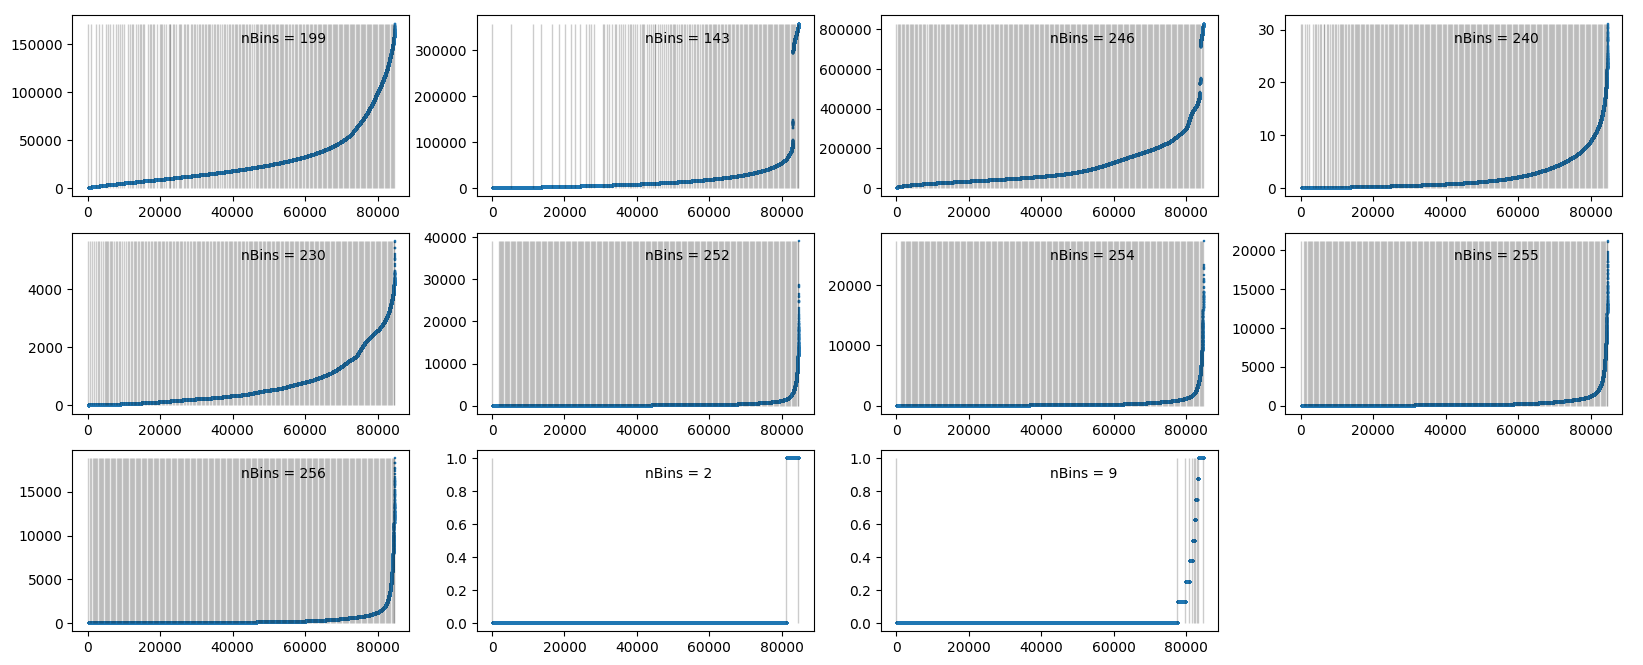

In [12]:
fig, ax = new_gax()

index = np.arange(x_train.shape[0])

for i in range(n_features):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.scatter(index, np.sort(x_train[:,i]), marker=",", s=(72/fig.dpi)**2)

    bins = get_bin_borders_from_bins(get_bins(features[i]))
    ax.vlines(bins, 0, np.max(x_train[:,i]), color="black", linewidth=1, alpha=0.2)

    ax.text(0.5, 0.85, f"nBins = {len(bins) - 1}", transform=ax.transAxes)

gax.set_xlabel("i")
gax.set_ylabel("index[i].key")

## Using a step function to display bins

In [98]:
def wrap_hist_overlay(xmin=None, xmax=None):
    index = np.arange(x_train.shape[0])
    fig, ax = new_gax()
    for i in range(n_features):
        ax = fig.add_subplot(3, 4, i + 1)

        data = np.sort(x_train[:,i])
        ax.scatter(index, data, marker=",", s=(72/fig.dpi)**2)

        bins = get_bin_borders_from_bins(get_bins(features[i]))
        averages = get_bin_averages(data, bins)
        ax.step(bins, averages, color="red", where="post")

        if xmin and xmax:
            ax.set_xlim(xmin, xmax)


    gax.set_xlabel("i")
    gax.set_ylabel("index[i].key")

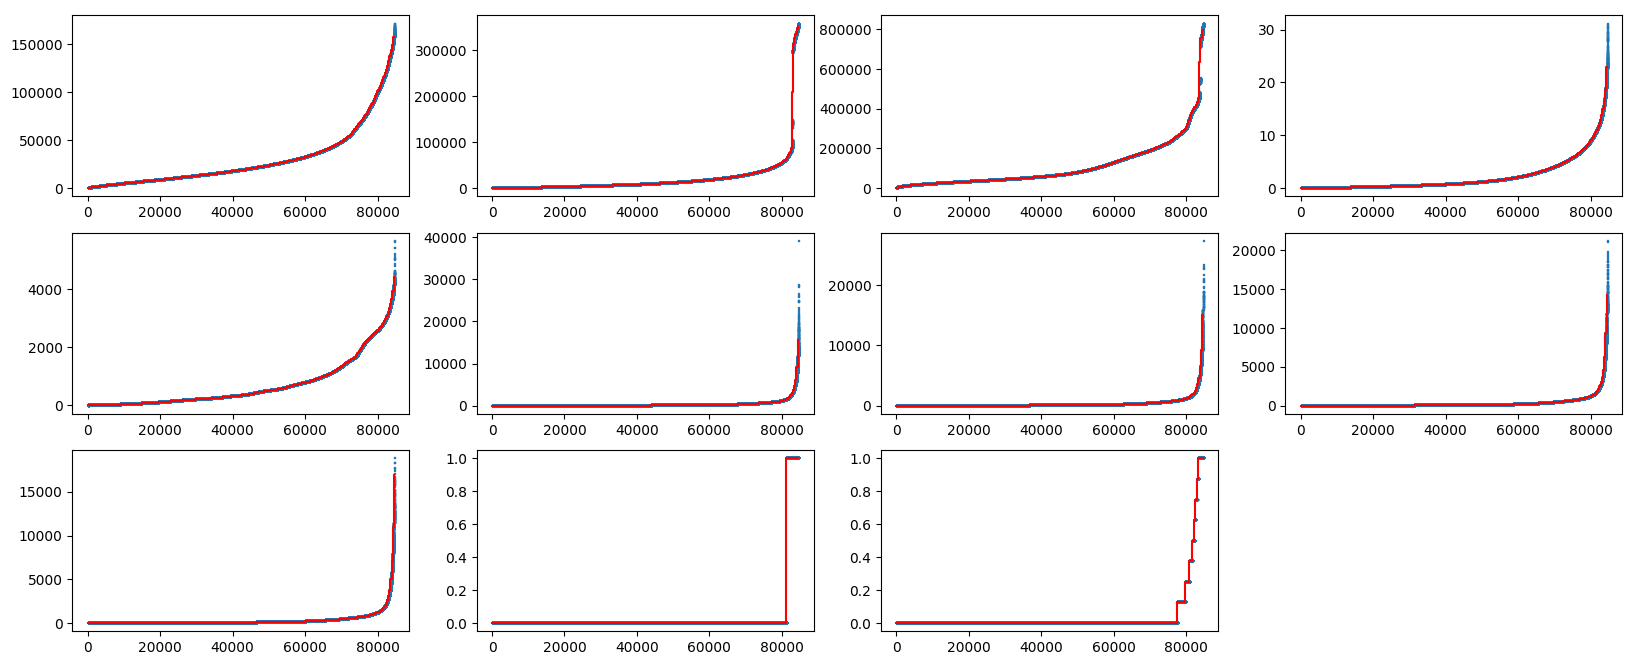

In [14]:
wrap_hist_overlay()

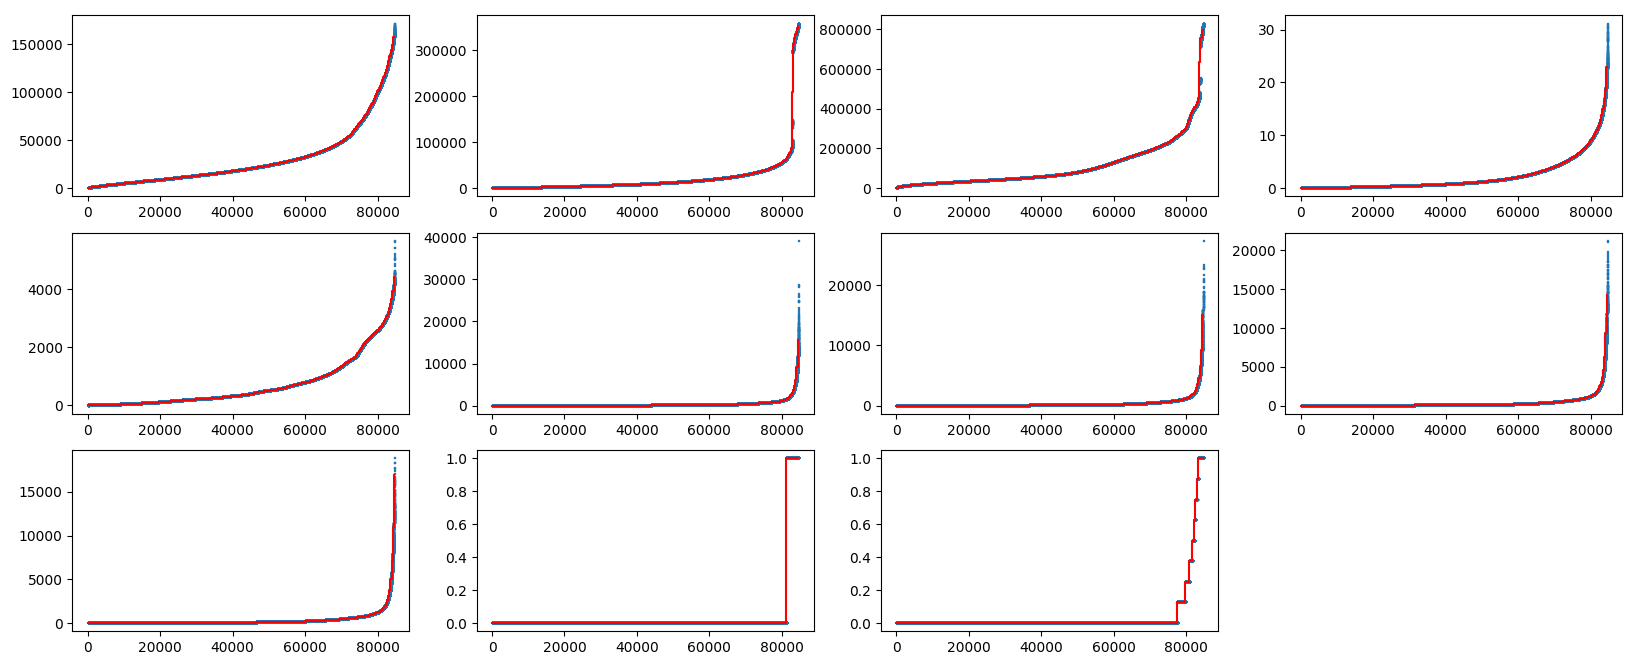

In [99]:
wrap_hist_overlay(0, 5000)

## Calculate standard deviation per bin

In [16]:
def wrap_std(xmin=None, xmax=None):
    fig, ax = new_gax()
    for i in range(n_features):
        ax = fig.add_subplot(3, 4, i + 1)

        data = np.sort(x_train[:,i])
        bins = get_bin_borders_from_bins(get_bins(features[i]))

        std = get_bin_std(data, bins)
        # duplicate final bin, otherwise where="post" wouldn't display it
        ax.step(bins, std, color="red", where="post")

        if xmin and xmax:
            ax.set_xlim(xmin, xmax)

    gax.set_xlabel("i")
    gax.set_ylabel("std per bin")

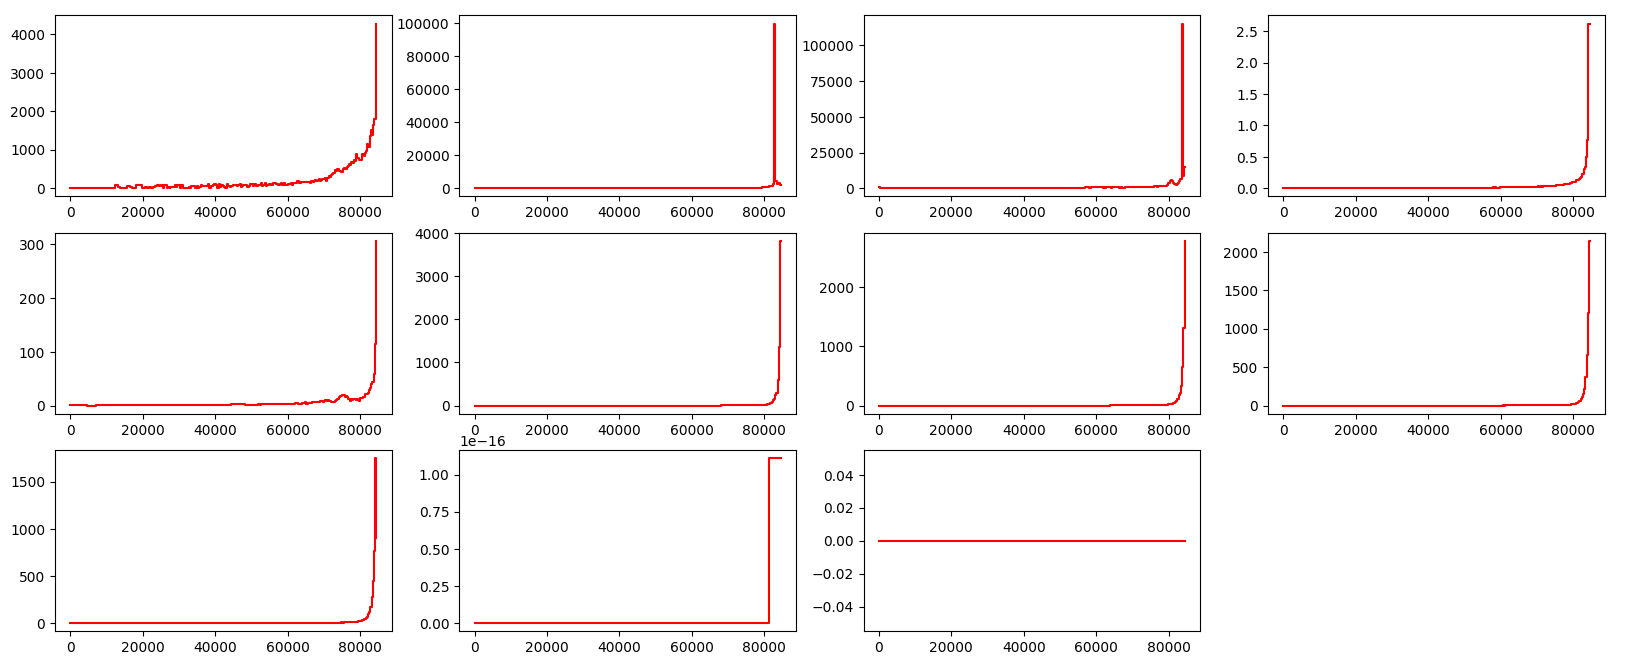

In [17]:
wrap_std()

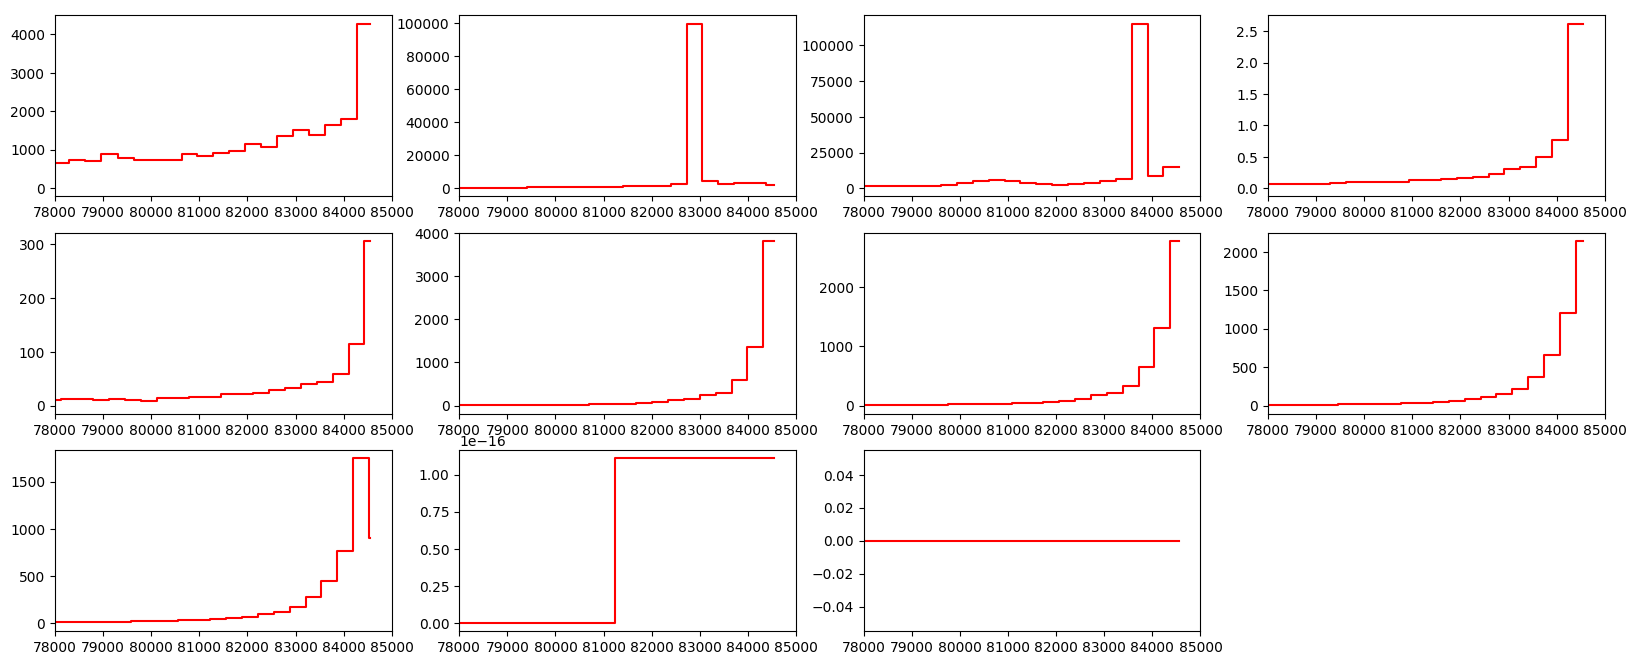

In [18]:
wrap_std(78000, 85000)

## Calculate the average error per bin

$$\frac{\sigma_i^2}{\bar{x_i}}$$

In [19]:
def wrap_error(xmin=None, xmax=None):
    fig, ax = new_gax()
    for i in range(n_features):
        ax = fig.add_subplot(3, 4, i + 1)

        data = np.sort(x_train[:,i])
        bins = get_bin_borders_from_bins(get_bins(features[i]))

        std = get_bin_std(data, bins)
        avg = get_bin_averages(data, bins)
        err = std/avg
        ax.step(bins, err, color="#b34259", where="post")

        ax.set_ylim(0, 1)

        if xmin and xmax:
            ax.set_xlim(xmin, xmax)

    gax.set_xlabel("i")
    gax.set_ylabel("std per bin")

/tmp/ipykernel_1976868/1721739140.py:11: RuntimeWarning: invalid value encountered in true_divide
  err = std/avg


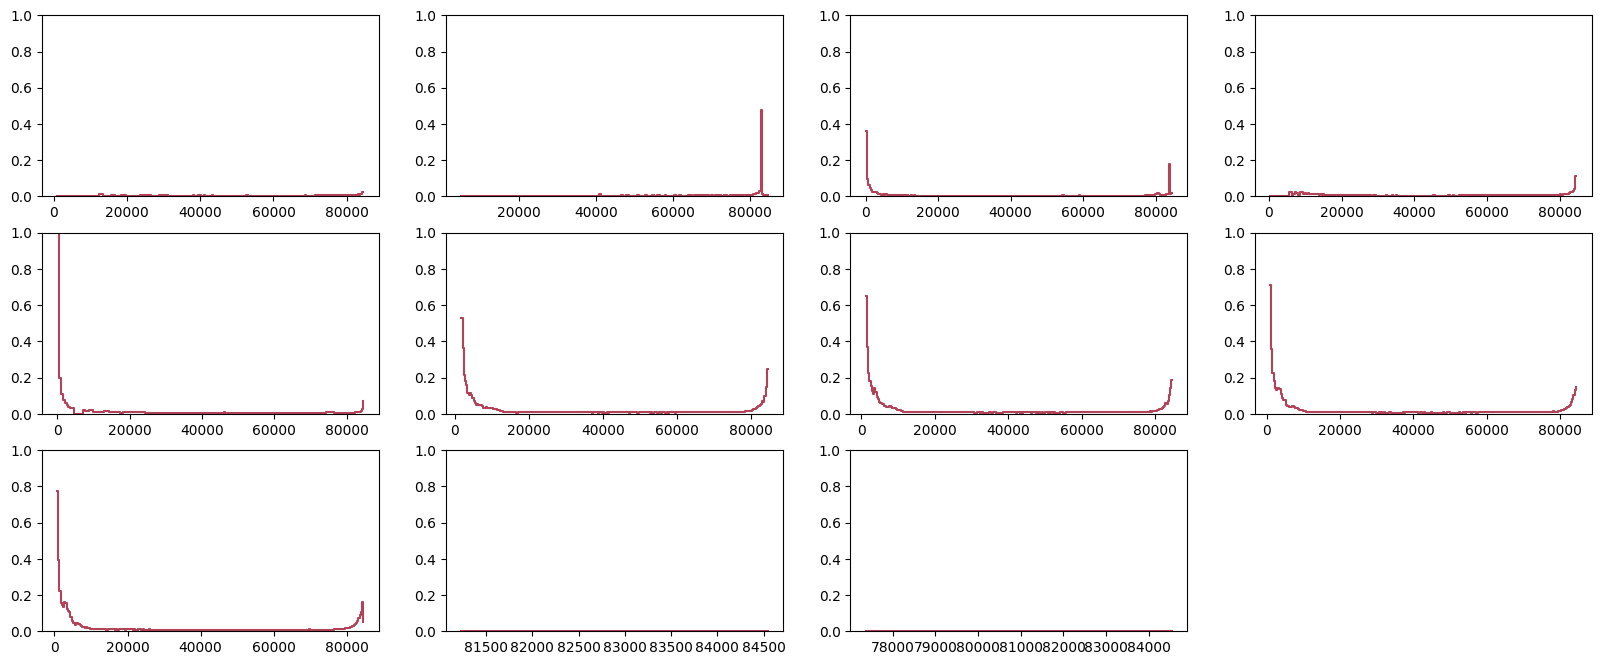

In [20]:
wrap_error()

## New binning: minimize std per bin

In [80]:
MIN_BIN_WIDTH = 5     # corresponds to minimum number of data points per bin
MIN_BIN_ERROR = 0.02  # bins with smaller relative error won't be split
MAX_BINS = 256        # maximum number of bins
SPLIT_STOP_ERROR = 1e-5

from functools import lru_cache

def get_bins_opt(data):
    @lru_cache(maxsize=None)
    def get_relative_error(start, stop):
        assert start != stop
        assert stop > start
        std = np.std(data[start:stop])
        mean = np.mean(data[start:stop]) + 1e-9
        return np.abs(std / mean)

    @lru_cache(maxsize=None)
    def get_relative_spread(start, stop):
        assert start != stop
        assert stop > start
        return (data[stop - 1] - data[start]) / (np.mean(data[start:stop]) + 1e-9)

    def get_spread(start, stop):
        assert start != stop
        assert stop > start
        return data[stop - 1] - data[start]

    def find_split_idx_naive(start, stop):
        assert stop - start > 1
        split = (start + stop) // 2
        # print(f"{start:8d} - {stop:8d} -> {split:8d}")
        left = get_relative_error(start, split)
        right = get_relative_error(split, stop)
        if left < right:
            if left < SPLIT_STOP_ERROR:
                return split
            return find_split_idx_naive(start, split)
        else:
            if right < SPLIT_STOP_ERROR:
                return split
            return find_split_idx_naive(split, stop)

    def find_split_idx_spread(start, stop):
        assert stop > start
        split = (start + stop) // 2
        # print(f"{start:8d} - {stop:8d} -> {split:8d}")
        assert split > start, split
        assert split < stop, split
        left = get_relative_spread(start, split)
        right = get_relative_spread(split, stop)
        if left < right:
            if left < SPLIT_STOP_ERROR:
                return split
            return find_split_idx_spread(start, split)
        else:
            if right < SPLIT_STOP_ERROR:
                return split
            return find_split_idx_spread(split, stop)

    def find_split_idx(start, stop):
        errors = list(get_relative_spread(start, i) + get_relative_spread(i, stop) for i in range(start + 1, stop, max(1, (stop - start) // (8 * MAX_BINS))))
        # best split is the index that produces the smallest combined relative error
        split = start + 1 + np.argmin(errors)
        # print(f"[{start}:{stop}] -> {split}")
        return split

    bins = [0, len(data)]
    while len(bins) < MAX_BINS:
        # find the bin with largest relative_error
        errors = list(get_relative_error(bins[i], bins[i+1]) for i in range(len(bins) - 1))
        # break if the maximum error is below threshold
        if np.max(errors) < MIN_BIN_ERROR:
            break
        max_error_index = np.argmax(errors)
        if bins[max_error_index + 1] - bins[max_error_index] == 1:
            # only one data entry in the max-error bin
            break
        # split the bin optimally
        best_split = find_split_idx_naive(bins[max_error_index], bins[max_error_index + 1])
        # print(f"{bins[max_error_index]:8d} - {bins[max_error_index + 1]:8d} -> {best_split:8d}")
        # update bins
        bins = bins[:max_error_index+1] + [best_split] + bins[max_error_index+1:]

    # merge equal-valued bins
    if len(bins) > 2:
        merged_bins = [bins[0]]  # always keep first bin
        averages = get_bin_averages(data, bins)
        for i in range(1, len(bins) - 2):
            if averages[i] != averages[i+1]:
                # the next bin has different value
                merged_bins.append(bins[i])
        merged_bins.append(bins[-1])  # always keep last bin
    
        return merged_bins
    else:
        return bins

### Debug the new binning strategy

In [81]:
# data = x_train[:,0]
# bins = get_bins_opt(data)
# print(len(bins))

data = np.sort(x_train[:,0])
bins = get_bins_opt(data)

assert bins[0] == 0
assert bins[-1] == len(data)

print(bins)
print(len(bins))


[0, 876, 2250, 3023, 3890, 5007, 5250, 5540, 6139, 6967, 7728, 7827, 8048, 8576, 8876, 9331, 9352, 9978, 10452, 10978, 11232, 11565, 11815, 12003, 12214, 12426, 12567, 13012, 13410, 14456, 14831, 15206, 15457, 15764, 16201, 16657, 16840, 17115, 17391, 17636, 18587, 18879, 19758, 19926, 20730, 21128, 21563, 22053, 22871, 23222, 23433, 23987, 24911, 25680, 25937, 26162, 26556, 27740, 28066, 28199, 28574, 30002, 30206, 30349, 31583, 32868, 34628, 34755, 35187, 35737, 37038, 38712, 40785, 42949, 44711, 45917, 47489, 47878, 49012, 50670, 51969, 53117, 54318, 55448, 55690, 55909, 57418, 57808, 59695, 60737, 61620, 62559, 63095, 63869, 64171, 64528, 65563, 66322, 66375, 66410, 66445, 67487, 69012, 69501, 70308, 70890, 71169, 71188, 71878, 72136, 72666, 72946, 73436, 74250, 74327, 74339, 74343, 74757, 75031, 75206, 76168, 76292, 76342, 76442, 76734, 76759, 76813, 76911, 77354, 78026, 78642, 78794, 79517, 79769, 79811, 80168, 80396, 80575, 80985, 81138, 81445, 81753, 82310, 82365, 82481, 82573,

### Visualize the new binning strategy

Text(35.06944444444445, 0.5, 'index[i].key')

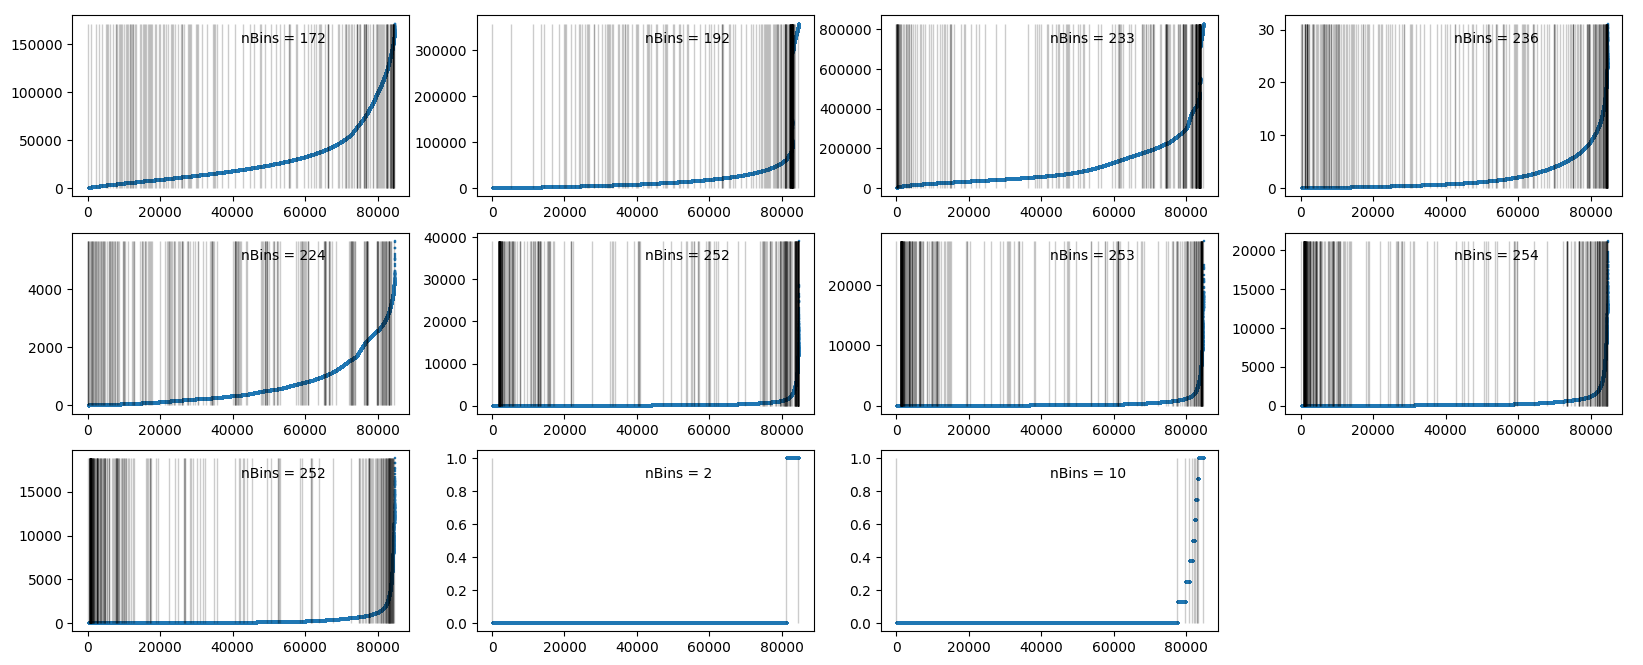

In [82]:
fig, ax = new_gax()

index = np.arange(x_train.shape[0])

for i in range(n_features):
    ax = fig.add_subplot(3, 4, i + 1)
    data = np.sort(x_train[:,i])
    ax.scatter(index, data, marker=",", s=(72/fig.dpi)**2)

    bins = get_bins_opt(data)
    ax.vlines(bins, 0, np.max(x_train[:,i]), color="black", linewidth=1, alpha=0.2)

    ax.text(0.5, 0.85, f"nBins = {len(bins) - 1}", transform=ax.transAxes)

gax.set_xlabel("i")
gax.set_ylabel("index[i].key")

## Histograms from new binning strategy

In [83]:
def wrap_hist_overlay_new_bins(xmin=None, xmax=None):
    index = np.arange(x_train.shape[0])
    fig, ax = new_gax()
    for i in range(n_features):
        ax = fig.add_subplot(3, 4, i + 1)

        data = np.sort(x_train[:,i])
        ax.scatter(index, data, marker=",", s=(72/fig.dpi)**2)

        bins = get_bins_opt(data)
        averages = get_bin_averages(data, bins)
        ax.step(bins, averages, color="red", where="post")

        if xmin and xmax:
            ax.set_xlim(xmin, xmax)


    gax.set_xlabel("i")
    gax.set_ylabel("index[i].key")

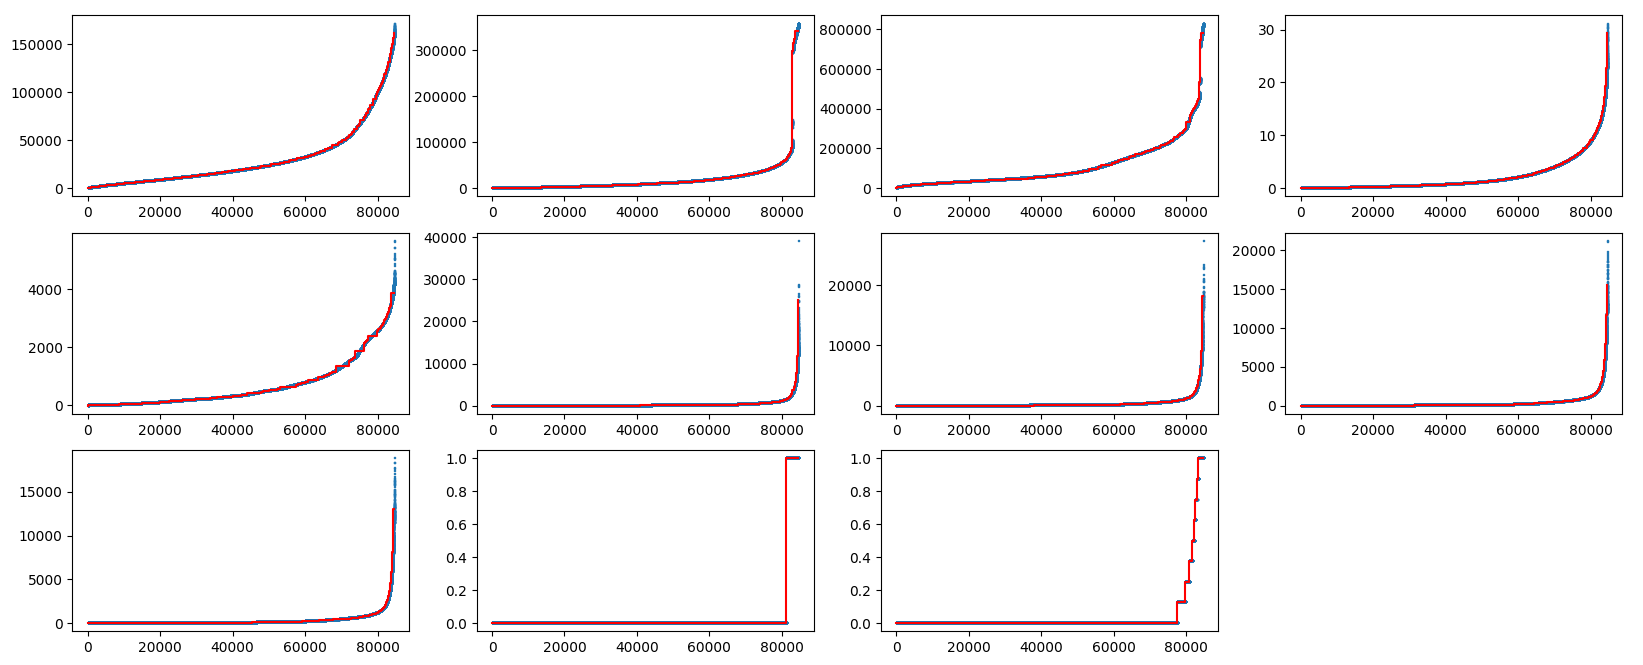

In [84]:
wrap_hist_overlay_new_bins()

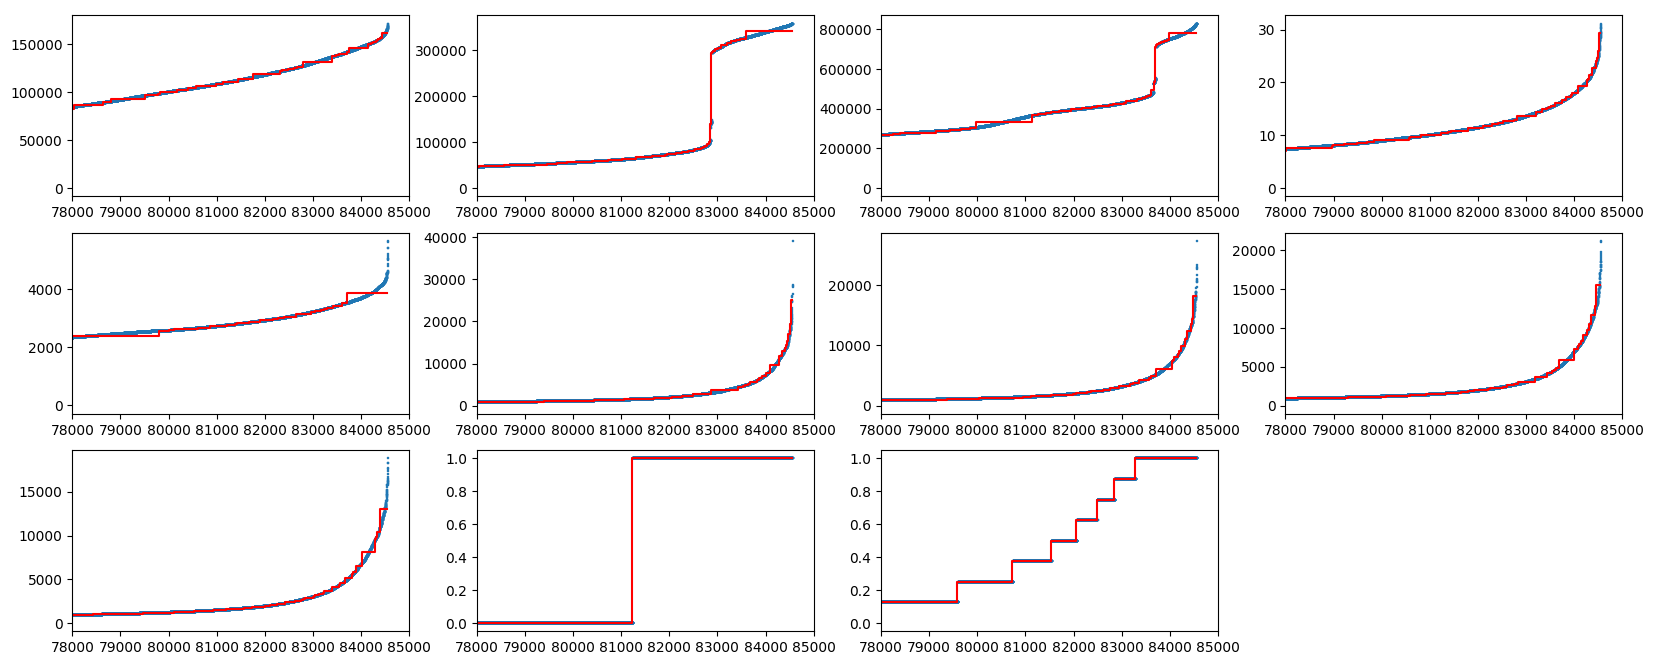

In [85]:
wrap_hist_overlay_new_bins(78000, 85000)

## Bin error for new binning strategy

In [86]:
def wrap_std_new(xmin=None, xmax=None):
    fig, ax = new_gax()
    for i in range(n_features):
        ax = fig.add_subplot(3, 4, i + 1)

        data = np.sort(x_train[:,i])
        bins = get_bins_opt(data)

        std = get_bin_std(data, bins)
        # duplicate final bin, otherwise where="post" wouldn't display it
        ax.step(bins, std, color="red", where="post")

        if xmin and xmax:
            ax.set_xlim(xmin, xmax)

    gax.set_xlabel("i")
    gax.set_ylabel("std per bin")

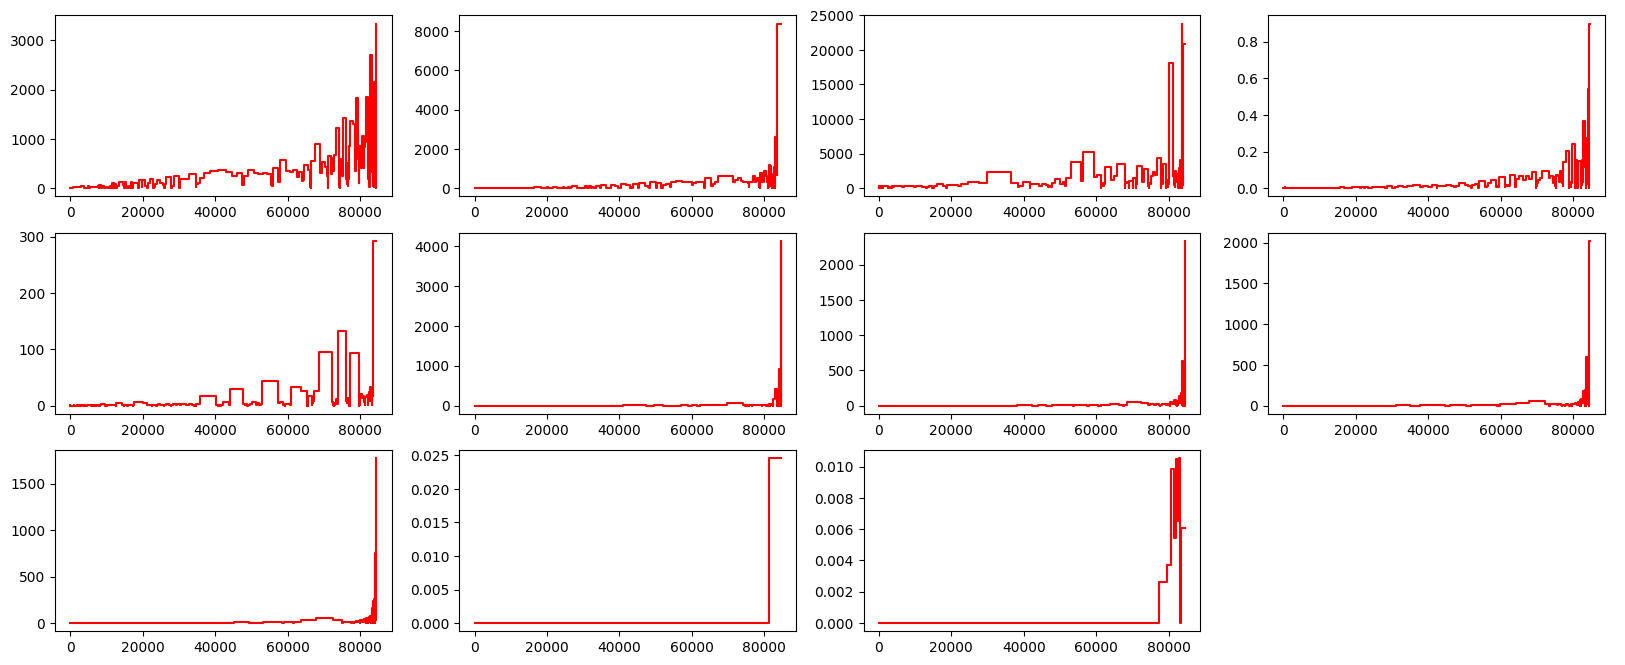

In [87]:
wrap_std_new()

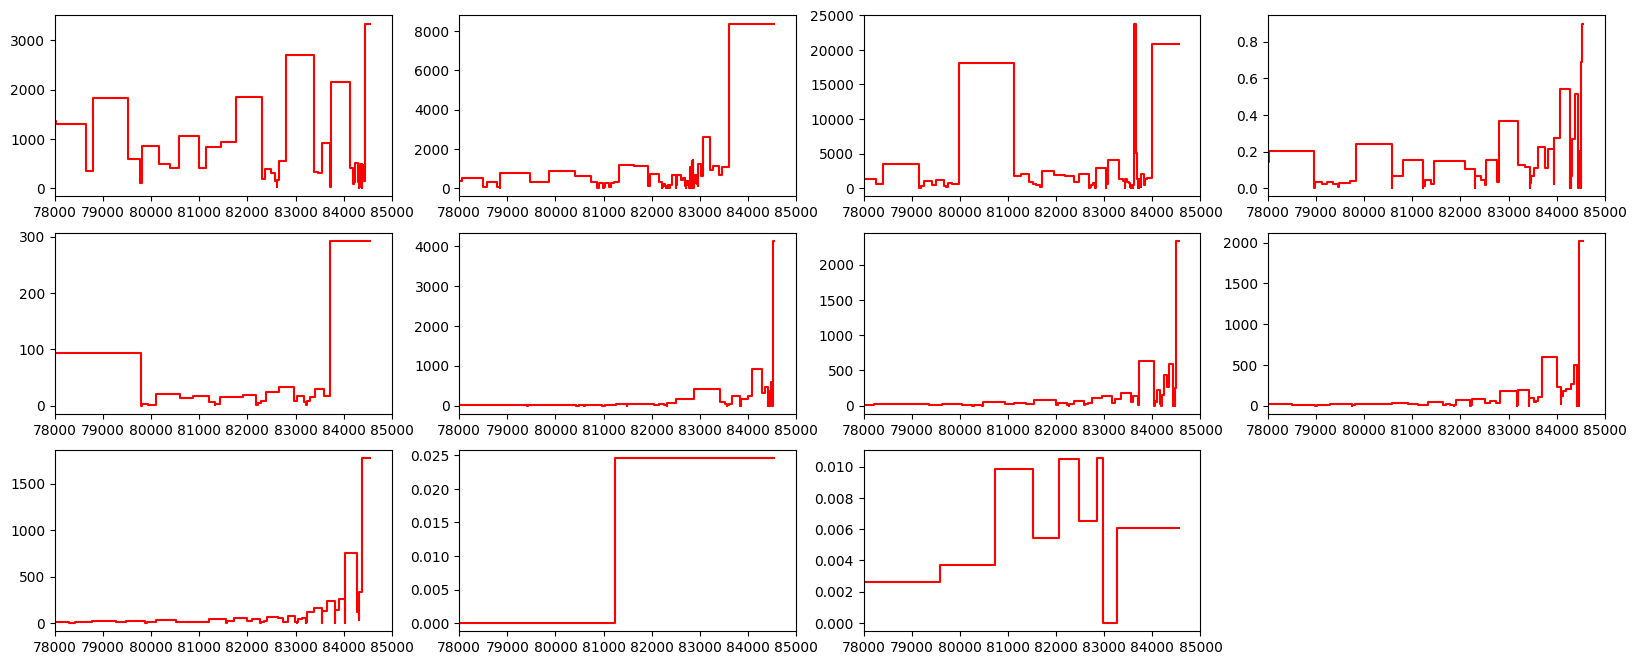

In [88]:
wrap_std_new(78000, 85000)

In [89]:
def wrap_error_new(xmin=None, xmax=None):
    fig, ax = new_gax()
    for i in range(n_features):
        ax = fig.add_subplot(3, 4, i + 1)

        data = np.sort(x_train[:,i])
        bins = get_bins_opt(data)

        spread = list((data[stop - 1] - data[start]) / (1e-9 + data[stop -1]) for start, stop in zip(bins, bins[1:]))
        spread.append(spread[-1])
        ax.step(bins, spread, color="#b34259", where="post")

        ax.set_ylim(0, 1.1)

        if xmin and xmax:
            ax.set_xlim(xmin, xmax)

    gax.set_xlabel("i")
    gax.set_ylabel("std per bin")

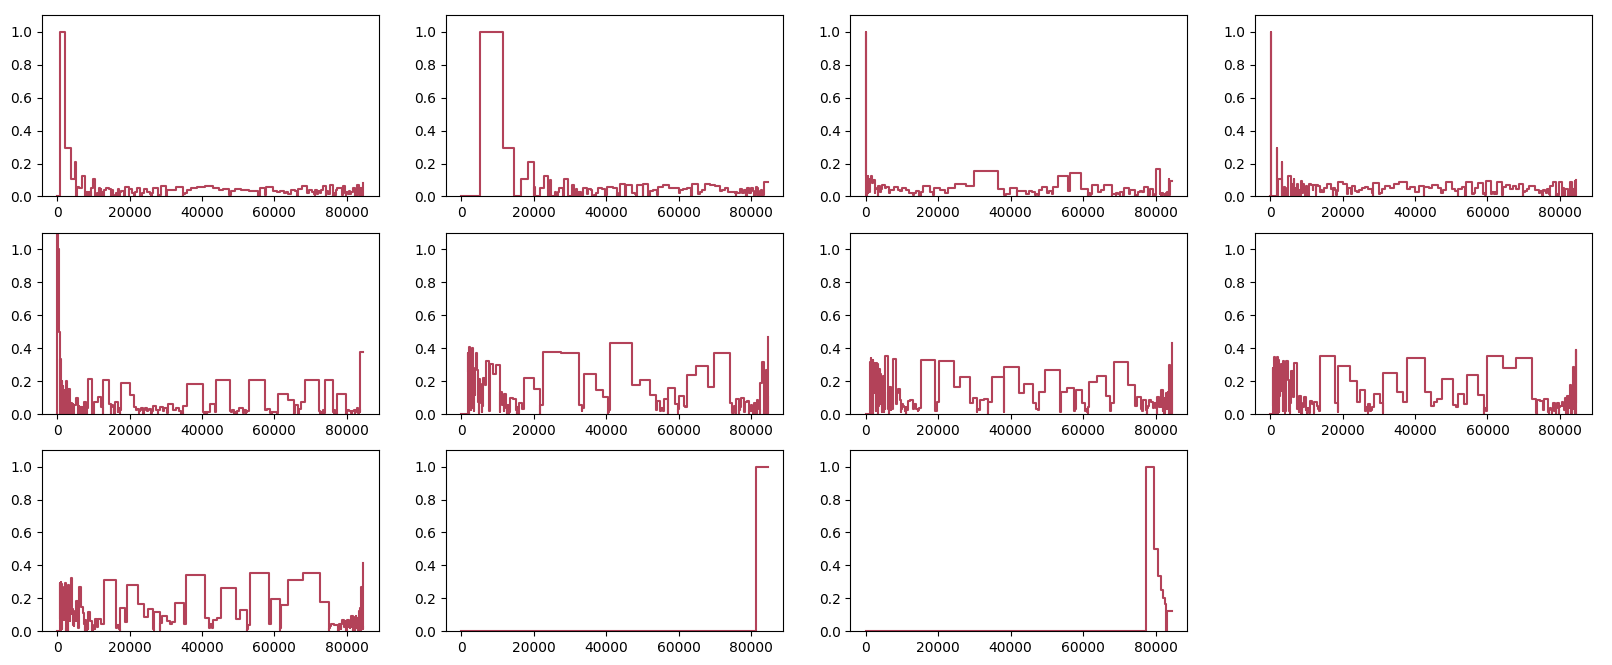

In [90]:
wrap_error_new()

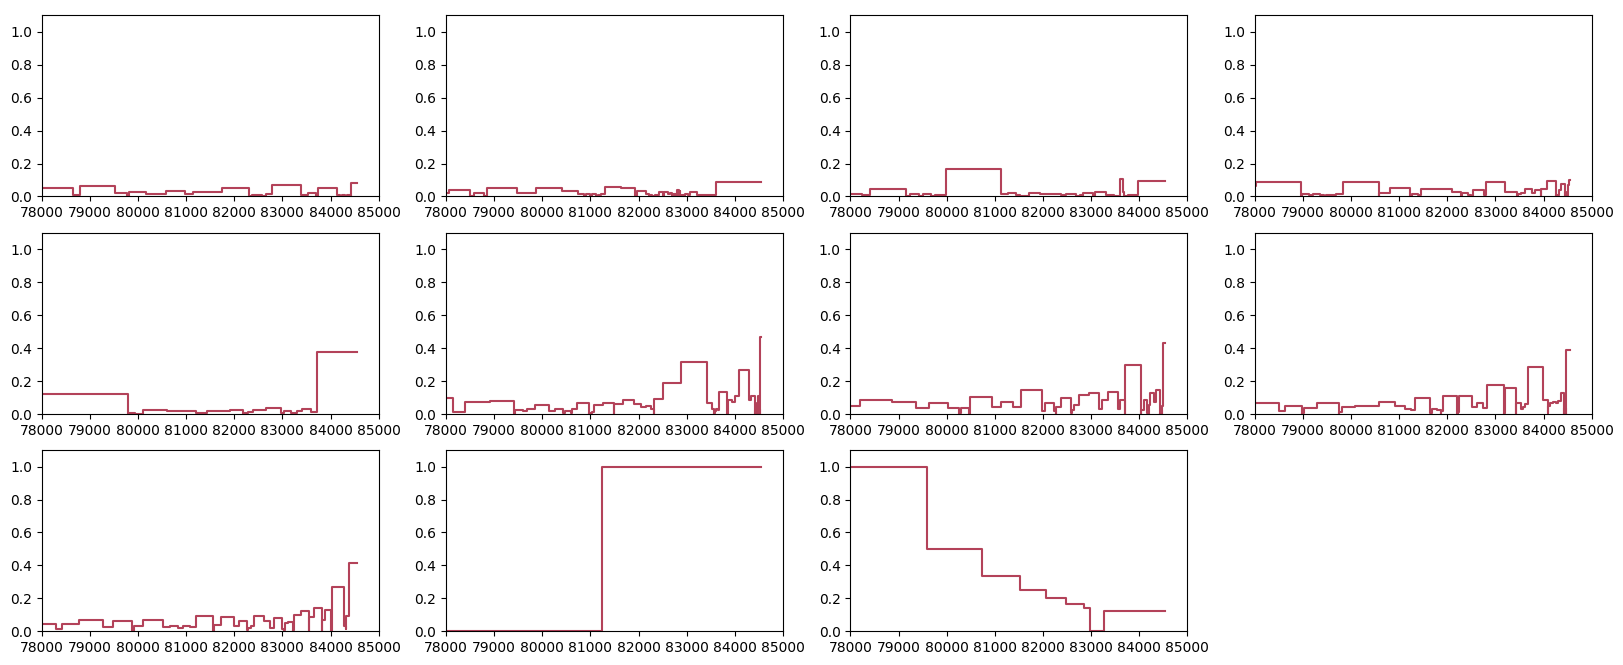

In [91]:
wrap_error_new(78000, 85000)

## Dynamic programming algorithm for optimal bins

http://www.primachvis.com/html/data_optbin.html

* $SE(s, p) = \sum_{i=s}^p (x_i - \frac{1}{p-s+1} \sum_{j=s}^p x_j)^2$
* Starting point: $SE_1(s) = SE(s, N)$, that is, $p=N$, the bin is anchored to the right
* Iteration: $SE_2(s) = \min_{p_2} \left\{ SE(s, p+2) + SE(p_2 + 1,N) \right\} = \min_{p_2} \left\{ SE(s, p_2) + SE_1(p_2 + 1) \right\}$
    * where $s < p_2$, and $p_2 + 1 < N$
* Next iteration: $SE_3 = \min_{p_3} \left\{ SE(s, p_3) + SE_2(p_3 + 1) \right\}$
* $s = 0$

In [58]:
MAX_BINS = 256
MIN_BIN_ERROR = 0.02

from dataclasses import dataclass

@dataclass
class ARGMIN:
    idx: np.intp
    val: float

def get_bins_dp(data):
    data_sq = np.square(data)

    def cum(data, p):
        return np.sum(data[:p+1])

    def u(s, p):
        # p_b = p + 1, p_{b-1} = s
        assert p - s != 0, f"s == p == {s}"
        return 1 / (p - s) * (cum(data, p) - cum(data, s))

    @lru_cache(maxsize=None)
    def SE(s, p):
        # p_b = p, p_{b-1} = s
        return (cum(data_sq, p) - cum(data_sq, s)) - (p - s) * np.power(u(s, p), 2)

    # @lru_cache(maxsize=None)
    # def SE(b):
    #     selection = data[s:p+1]
    #     return np.sum(np.power((selection - np.sum(selection) / (p - s + 1)), 2))

    def split(SE_prev):
        def s(s):
            metric = list(SE(s, p_next) + SE_prev(p_next+1).val for p_next in range(s + 1, len(data) - 2))
            min_idx = np.argmin(metric)
            return ARGMIN(idx=min_idx, val=metric[min_idx])
        return s

    SE1 = lambda s: ARGMIN(idx=0, val=SE(s, len(data) - 1))
    se = [SE1]
    while len(se) < MAX_BINS:
        se.append(split(se[-1]))

    return se[-1]   

In [59]:
se = get_bins_dp(x_train[0:,i])
print(se(0))

KeyboardInterrupt: 

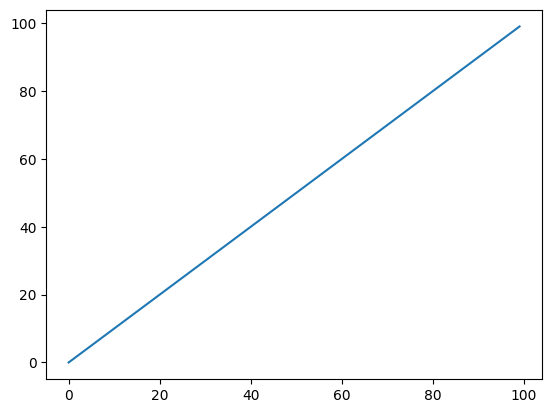

In [94]:
fig, ax = plt.subplots()
x = np.arange(100)
ax.plot(x, x)
